# Predict Future Sales

Notes from the competition host:

*This challenge serves as final project for the "How to win a data science competition" Coursera course.*

*In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company.*

*We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.*

*Submissions are evaluated by root mean squared error (RMSE). **True target values are clipped into [0,20] range**.*

*For each id in the test set, you must predict a total number of sales.*

# Import Libraries, First Steps of Analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd

pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1500)

import warnings

import sys
import calendar
import datetime
import os

# Input data files are available in the read-only '../input/' directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from itertools import product
import random
import gc
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from lightgbm import LGBMRegressor,plot_importance
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using 'Save & Run All'
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Loading only train and test sets here.<br> We have more input data than these two; however, due to high memory use of these files, I will import the others later, right when I need them.<br> Additionally, to utilize the use of local variables and reduce memory footprint, I wrapped most of the code in functions.

In [3]:
random.seed(35)
  
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

A small utility function to downcast dataframe throughout the notebook as we're working with large amount of data.

In [4]:
def downcast_df(df):

    before = df.memory_usage()
    # skip any columns with nan to prevent crash
    cols_to_skip = df.isna().sum()[df.isna().sum() > 0].index
    numcols = [
        col for col in df.select_dtypes("number").columns if col not in cols_to_skip
    ]
    ints = df.select_dtypes(int).columns
    floats = df.select_dtypes(float).columns

    for col in ints:
        df[col] = pd.to_numeric(df[col].values, downcast="integer")
    for col in floats:
        df[col] = pd.to_numeric(df[col].values, downcast="float")

    after = df.memory_usage()
    reduction = (before - after) / before * 100

    comparison = pd.concat([before, after, reduction], axis=1)
    comparison.columns = [
        "before",
        "after",
        "reduction(%)",
    ]

    print(f"Downcasting: \n  {comparison}\n\n")

    return df


df = downcast_df(train)
df = downcast_df(test)


Downcasting: 
                    before     after  reduction(%)
Index                128       128          0.00
date            23486792  23486792          0.00
date_block_num  23486792   2935849         87.50
shop_id         23486792   2935849         87.50
item_id         23486792   5871698         75.00
item_price      23486792  11743396         50.00
item_cnt_day    23486792  11743396         50.00


Downcasting: 
            before   after  reduction(%)
Index        128     128          0.00
ID       1713600  856800         50.00
shop_id  1713600  214200         87.50
item_id  1713600  428400         75.00




In [5]:
print(f'Train set contains {train.shape[0]} rows,{train.shape[1]} columns. \nTest set contains {test.shape[0]} rows, {test.shape[1]} columns.\n')
print(f'These are the features in TRAIN and NOT in TEST ->{set(train.columns) - set(test.columns)}.\nThese are the features in TEST and NOT in TRAIN -> {set(test.columns) - set(train.columns)}')

Train set contains 2935849 rows,6 columns. 
Test set contains 214200 rows, 3 columns.

These are the features in TRAIN and NOT in TEST ->{'date', 'item_price', 'date_block_num', 'item_cnt_day'}.
These are the features in TEST and NOT in TRAIN -> {'ID'}


Checking the data types and missing value counts in train and test sets

In [6]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int8   
 2   shop_id         2935849 non-null  int8   
 3   item_id         2935849 non-null  int16  
 4   item_price      2935849 non-null  float32
 5   item_cnt_day    2935849 non-null  float32
dtypes: float32(2), int16(1), int8(2), object(1)
memory usage: 56.0+ MB


In [7]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int32
 1   shop_id  214200 non-null  int8 
 2   item_id  214200 non-null  int16
dtypes: int16(1), int32(1), int8(1)
memory usage: 1.4 MB


Looking at a sample of records from train and test sets

In [8]:
train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1863025,05.07.2014,18,25,4573,299.00,1.00
1639187,08.05.2014,16,30,3934,2799.00,1.00
703535,18.07.2013,6,58,3267,299.00,1.00
162219,13.02.2013,1,22,19345,400.00,1.00
71339,23.01.2013,0,31,14447,499.00,2.00


In [9]:
test.sample(5)

,ID,shop_id,item_id
6008,6008,4,20404
60159,60159,25,2700
40069,40069,12,5768
150458,150458,59,5539
213148,213148,45,10944


Descriptive statistics as follows:

In [10]:
train.drop(columns=['item_id','shop_id']).describe()

,date_block_num,item_price,item_cnt_day
count,2935849.00,2935849.00,2935849.00
mean,14.57,890.62,1.24
std,9.42,1726.44,2.61
min,0.00,-1.00,-22.00
25%,7.00,249.00,1.00
50%,14.00,399.00,1.00
75%,23.00,999.00,1.00
max,33.00,307980.00,2169.00


-> There are negative sales quantities (item_cnt_day). I assume they indicate returns. <br>
-> There is also negative item price. I assume this is an error and needs to be corrected.

Modifying the test dataframe so that the columns align with train df.

In [11]:
test = test.drop('ID', axis=1)

test['date'] = '01.11.2015'
test['date_block_num'] = 34
test['item_cnt_day'] = np.nan
test['item_price'] = np.nan

Taking a closer look at the record(s) with the negative item price.

In [12]:
train[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.00,1.00


Only one item shows negative price. Checking other records for the same item/shop to see the other prices used.

In [13]:
train[(train['item_id']==2973)&(train['shop_id']==32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,29.01.2013,0,32,2973,2499.00,1.00
67428,25.01.2013,0,32,2973,2499.00,1.00
67429,22.01.2013,0,32,2973,2499.00,1.00
67430,21.01.2013,0,32,2973,2499.00,1.00
67431,18.01.2013,0,32,2973,2499.00,1.00
67432,17.01.2013,0,32,2973,2499.00,1.00
67433,15.01.2013,0,32,2973,2499.00,3.00
187844,05.02.2013,1,32,2973,2499.00,1.00
187845,14.02.2013,1,32,2973,2499.00,1.00
484682,23.05.2013,4,32,2973,1249.00,1.00


Imputing the negative item price with the most common occurrance -> 2499

In [14]:
train.loc[train['item_price']<0,'item_price'] = 2499

Applying grouping to train and test dataframes so that they show monthly sales qty instead of daily.<br> This is because we're asked to provide the forecast at a monthly level.<br> I am also clipping the target variable between 0 and 20 per the instructions.

In [15]:
train = train.groupby(by=["date_block_num", "shop_id", "item_id"], as_index=False).agg(
    {"item_cnt_day": "sum", "item_price": "mean", "date": "first"})

train = train.rename(columns={"item_cnt_day": "item_cnt_month"})
test = test.rename(columns={"item_cnt_day": "item_cnt_month"})

train["item_cnt_month"] = train["item_cnt_month"].clip(0, 20)

# Detect Outliers

Checking the item price for outliers below.

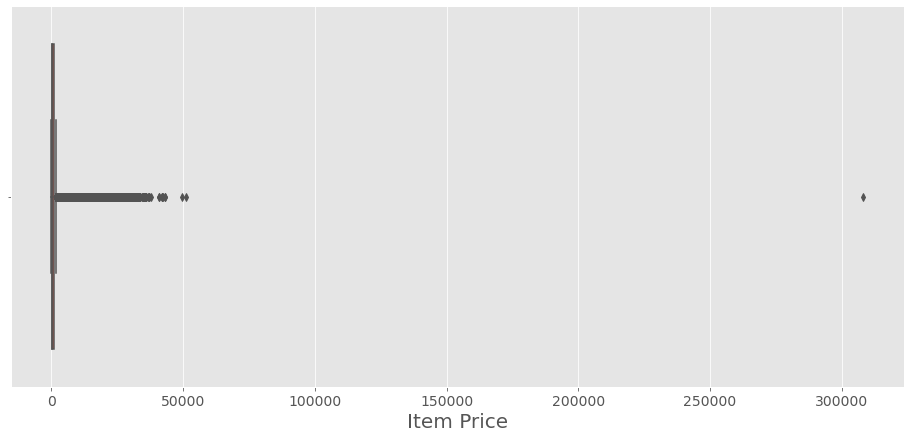

In [16]:
def plot_for_outlier(ft, name):
    plt.style.use("ggplot")
    params = {
        "axes.labelsize": 20,
        "xtick.labelsize": 14,
    }
    plt.rcParams.update(params)

    fig, ax = plt.subplots(figsize=(16, 7))

    plot1 = sns.boxplot(x=train[ft])

    plot1.set_xlabel(name)

    return fig.show()


plot_for_outlier("item_price", "Item Price")

In [17]:
train[train["item_price"] > 100000]

,date_block_num,shop_id,item_id,item_cnt_month,item_price,date
629348,11,12,6066,1.00,307980.00,13.12.2013


Removing one extreme outlier from the equation.

In [18]:
train = train[train["item_price"] < 100000]

Visualizing the item price again to see the changes.

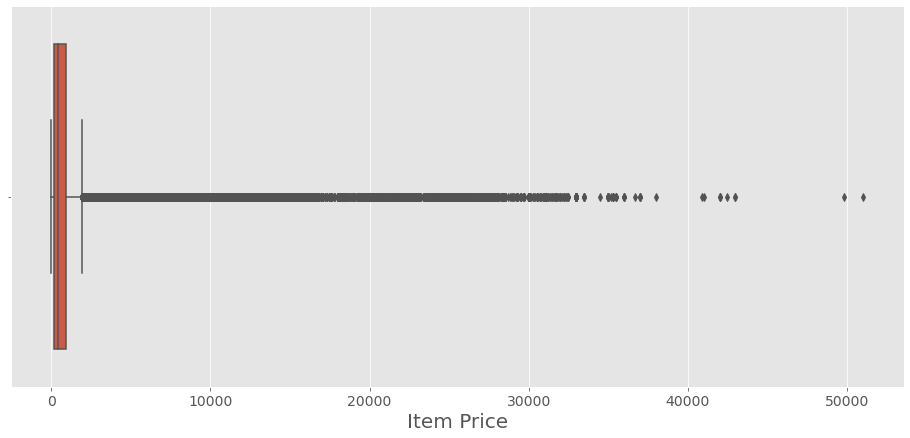

In [19]:
plot_for_outlier('item_price','Item Price')

Looks a bit better.<br>

# Univariate Vizualization

In the next two steps, I'll visualize value distributions for item_cnt_month and shop_id.

In [20]:
def plot_value_dist(df, var, name):

    x = df[var].value_counts().index
    y = df[var].value_counts().values

    fig = go.Figure(data=[go.Bar(x=x, y=y, text=y, textposition="outside")])

    fig.update_traces(
        marker_color="darkblue",
        marker_line_color="white",
        texttemplate="%{text:.2s}",
        width=1.2,
        textfont=dict(size=18),
        textposition="inside",
        marker_line_width=2,
        opacity=0.6,
    )

    fig.update_xaxes(
        title_text=name, titlefont=dict(size=18), nticks=20, tickfont=dict(size=16)
    )
    fig.update_yaxes(
        title_text="Value Counts", titlefont=dict(size=18), tickfont=dict(size=16)
    )

    fig.update_layout(
        height=500,
        width=800,
        template="ggplot2",
        title=go.layout.Title(
            text=name + " - Value Distribution", font=dict(size=20, color="darkslateblue")
        ),
    )

    return fig.show()


plot_value_dist(train, "item_cnt_month", "Item Cnt Month")

A large majority of the monthly sales quantity are 1.<br> There are zero values. These came to surface because we clipped the sales quantity in the previous steps. They were most likely negative sales quantities before clipping.

In [21]:
plot_value_dist(train, "shop_id", "Shop ID")

There seems to be great variation in terms of the number of transactions per shop.<br> Does this high variance indicate the potential significance of the independent variable for the model ?

# Bivariate Visualization

Plotting unique item counts, unique shop counts, and unique item/shop combinations per date block. Blue bar represents the test set.

In [22]:
def plot_counts(ft, name):
    fig = plotly.graph_objects.Figure()

    vizdata = (
        train.append(test, ignore_index=True)
        .groupby(by=["date_block_num"], as_index=False)[ft]
        .nunique()
    )

    colors = [
        "indianred",
    ] * vizdata.shape[0]
    colors[-1] = "blue"

    fig.add_trace(
        go.Bar(
            x=vizdata["date_block_num"],
            y=vizdata[ft],
            width=0.9,
            marker_color=colors,
            name="Unique" + name + "Count",
        )
    )

    fig.update_xaxes(
        title_text="Date Block", titlefont=dict(size=20), tickfont=dict(size=16)
    )
    fig.update_yaxes(
        title_text="Total Unique " + name + " Count",
        titlefont=dict(size=20),
        nticks=8,
        tickfont=dict(size=16),
    )

    fig.update_layout(
        height=500,
        width=750,
        template="ggplot2",
        title=go.layout.Title(
            text="Unique " + name + " Counts by Date Block (Incl. Test data)",
            font=dict(size=20, color="darkslateblue"),
        ),
    )

    return fig.show()


In [23]:
plot_counts(ft = 'item_id', name='Item')

In [24]:
plot_counts(ft = 'shop_id', name='Shop')

In [25]:
def plot_combined():
    fig = plotly.graph_objects.Figure()

    vizdata = (
        train.append(test, ignore_index=True)
        .groupby(by=["date_block_num"], as_index=False)
        .size()
    )

    colors = [
        "indianred",
    ] * vizdata.shape[0]
    colors[-1] = "blue"

    fig.add_trace(
        go.Bar(
            x=vizdata["date_block_num"],
            y=vizdata["size"],
            width=0.9,
            marker_color=colors,
            name="Unique Item Count",
        )
    )

    fig.update_xaxes(
        title_text="Date Block", titlefont=dict(size=20), tickfont=dict(size=16)
    )
    fig.update_yaxes(
        title_text="Total Unique Item Count",
        titlefont=dict(size=20),
        nticks=8,
        tickfont=dict(size=16),
    )

    fig.update_layout(
        height=500,
        width=750,
        template="ggplot2",
        title=go.layout.Title(
            text="Item-Shop Combination Counts by Date Block (Incl. Test data)",
            font=dict(size=20, color="darkslateblue"),
        ),
    )

    return fig.show()


plot_combined()


Test set contains all item/shop combinations, unlike the train set where **only** item/shop combinations **with sales** are included.<br><br> Below I'll be extending the train dataframe to include all item/shop combinations just like the test set.<br> Applying cartesian multiplication to each unique item and shop set per date block.

In [26]:
%%time

def extend_train():
    '''
    1) Obtain set of date blocks
    2) Establish date and price lookup tables
    3) Get artesian product of shop/item pairs 
        and append them to train_extended_list
    4) Lookup the existing information from train set to the extended train set:
        Item_cnt_month nan --> fill with zero
        Item price nan --> fill with avg. price for the date block
        Sale date --> Lookup based on date block num
    '''
    dblocklist = train["date_block_num"].unique()
    dblock_month = (
        train[["date_block_num", "date"]]
        .drop_duplicates()
        .set_index("date_block_num")
        .to_dict()["date"]
    )
    item_price = train.groupby(by=["item_id", "date_block_num"])["item_price"].mean()

    
    train_extended_list = []
    for dblock in dblocklist:
        shops_dblock = train.loc[train["date_block_num"] == dblock, "shop_id"].unique()
        items_dblock = train.loc[train["date_block_num"] == dblock, "item_id"].unique()
        cartesian_prod = list(product(*[items_dblock, shops_dblock, [dblock]]))
        train_extended_list.append(np.array(cartesian_prod))

    train_extended_list = np.vstack(train_extended_list)

    train_extended = pd.DataFrame(
        train_extended_list, columns=["item_id", "shop_id", "date_block_num"]
    )
    train_extended = train_extended.merge(
        train, on=["item_id", "shop_id", "date_block_num"], how="left"
    )
    train_extended["item_cnt_month"].fillna(0, inplace=True)

    train_extended["date"] = train_extended["date_block_num"].map(dblock_month)
    train_extended["item_price"] = train_extended.set_index(
        ["item_id", "date_block_num"]
    ).index.map(item_price)

    train_extended["train"] = 1
    test["train"] = 0

    return train_extended.append(test).reset_index(drop=True)


df = extend_train()

del train, test

CPU times: user 37.7 s, sys: 6.87 s, total: 44.6 s
Wall time: 44.3 s


In the following step I'll obtain supplamental item category and shop data, and map them back to our dataframe.<br> In addition, I'll be extracting month and year info from the date column.

In [27]:
%%time

def get_cat_shop_info(df):
    '''
    1) Load items, shops, and itemcategories files
    2) Map item category id, item category name, shop name
    '''
    
    itemsdf = pd.read_csv(
        "../input/competitive-data-science-predict-future-sales/items.csv")
    shopsdf = pd.read_csv("../input/filestranslated/shops-translated.csv")
    itemcatsdf = pd.read_csv("../input/filestranslated/categories_translated.csv")

    item_cat = dict(zip(itemsdf["item_id"], itemsdf["item_category_id"]))
    item_cat_name = dict(
        zip(itemcatsdf["item_category_id"], itemcatsdf["item_category_name"]))
    shop_name = dict(zip(shopsdf["shop_id"], shopsdf["shop_name_translated"]))
    
    df["item_cat_id"] = df["item_id"].map(item_cat)
    df["item_cat_name"] = df["item_cat_id"].map(item_cat_name)
    df["shop_name"] = df["shop_id"].map(shop_name)

    return df


def extract_month_year(df):
    '''
    Extract month and year from date string
    '''
    df["month"] = df["date"].apply(lambda x: x.split(".")[1]).astype(int)
    df["year"] = df["date"].apply(lambda x: x.split(".")[2]).astype(int)

    df.drop(columns="date", inplace=True)

    return df



df = get_cat_shop_info(df)
df = extract_month_year(df)

CPU times: user 13 s, sys: 2.29 s, total: 15.3 s
Wall time: 15.3 s


New features added, downcasting df again.

In [28]:
gc.collect()
df = downcast_df(df)

Downcasting: 
                    before     after  reduction(%)
Index                128       128          0.00
item_id         89024032  22256008         75.00
shop_id         89024032  11128004         87.50
date_block_num  89024032  11128004         87.50
item_cnt_month  44512016  44512016          0.00
item_price      89024032  44512016         50.00
train           89024032  11128004         87.50
item_cat_id     89024032  11128004         87.50
item_cat_name   89024032  89024032          0.00
shop_name       89024032  89024032          0.00
month           89024032  11128004         87.50
year            89024032  22256008         75.00




Combining duplicate/relocated shop ids and names

In [29]:
df.loc[df["shop_id"] == 11, "shop_id"] = 10
df.loc[df["shop_id"] == 10, "shop_name"] = "Zhukovsky st. Chkalov 39m?"
df.loc[df["shop_id"] == 0, "shop_id"] = 57
df.loc[df["shop_id"] == 57, "shop_name"] = "Yakutsk Ordzhonikidze, 56"
df.loc[df["shop_id"] == 1, "shop_id"] = 58
df.loc[df["shop_id"] == 58, "shop_name"] = 'Yakutsk TC "Central"'
df.loc[df["shop_id"] == 40, "shop_id"] = 39
df.loc[df["shop_id"] == 39, "shop_name"] = "Rostov-on-Don Megacenter Horizon"

# Item Price Imputation

In the following step, I'll be imputing the missing item prices on test df.<br> Before the imputation, though, I want to see item prices per category - since I'll be using item category to infer item prices (for test items that don't exist in train).

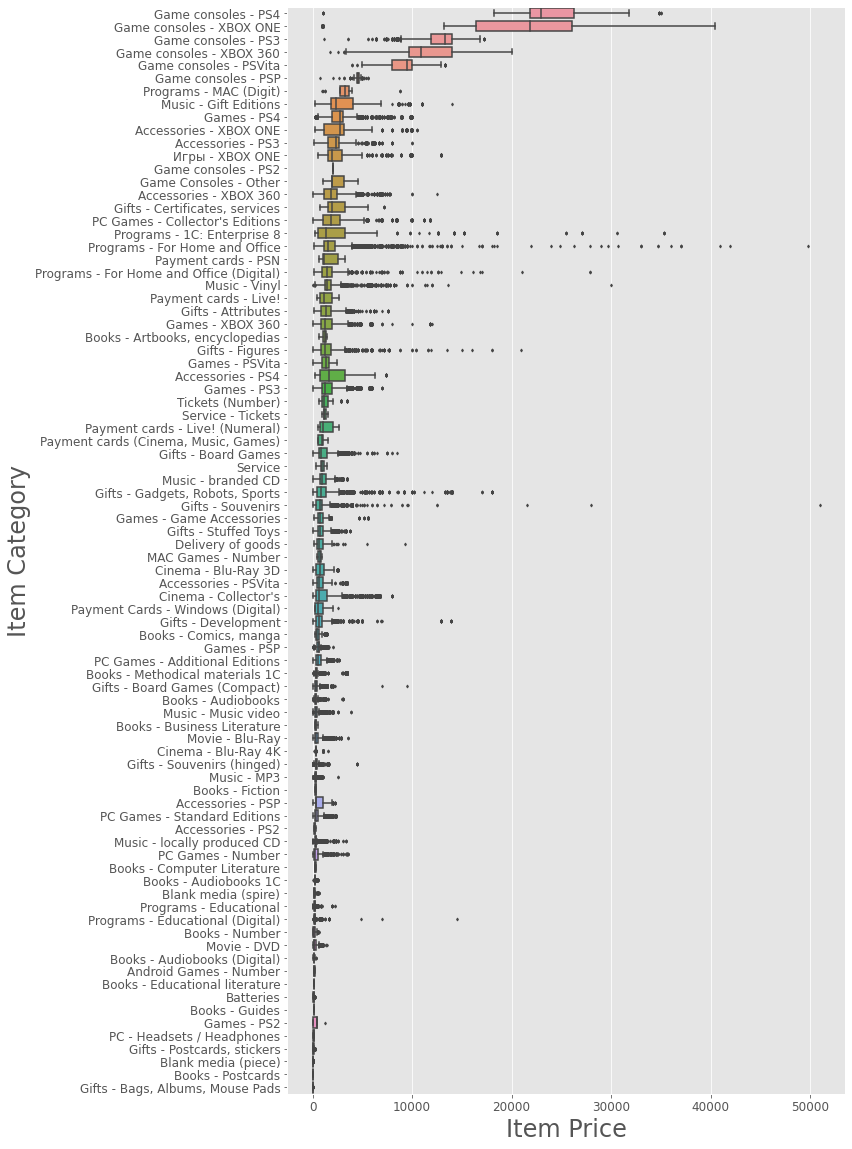

In [30]:
def plot_price_per_cat_shop(df, priceby, name):
    train_prices = df.loc[df["item_cnt_month"] > 0,["item_price", "shop_name", "item_cat_name"]]

    plt.style.use("ggplot")
    params = {
        "axes.labelsize": 24,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
    plt.rcParams.update(params)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))

    ordered = (
        df.groupby(by=priceby)["item_price"].median().sort_values(ascending=False).index
    )

    plot = sns.boxplot(
        y=train_prices[priceby],
        x=train_prices["item_price"],
        order=ordered,
        fliersize=2,
    )

    plot.set_xlabel("Item Price")
    plot.set_ylabel(name)

    return fig

plot_price_per_cat_shop(df, priceby="item_cat_name", name="Item Category").show()

Imputing iteratively to make the most of the available information.

In [31]:
def get_nan_count(df, imputee):
    nancount = df["item_price"].isna().sum()
    if nancount > 0:
        print(
            f"Remaining nan counts after imputation using price per {imputee}: {nancount}"
        )
    elif nancount == 0:
        print("No more missing values!")


def impute_test_prices(df):
    '''
    1) Sort the train dataframe to show most recent records at the top
    2) Obtain the most recent avg. price per item/shop
    3) Obtain the most recent avg. price per item regardless of shop
    4) Obtain the most recent avg. price per category/shop
    5) Obtain the most recent avg. price per category, regardless of shop
    6) Impute the missing item prices incrementally (same order as above)
    '''
    
    sorted_train = df[(df["train"] == 1) & (df["item_cnt_month"] > 0)].sort_values(
        by=["date_block_num"], ascending=False
    )
    
    itemNshop_price = sorted_train.groupby(by=["item_id", "shop_id"], sort=False)[
        "item_price"
    ].first()

    
    item_price = sorted_train.groupby(
        by=["item_id", "date_block_num"], as_index=False, sort=False
    )["item_price"].mean()
    item_price = item_price.groupby(by=["item_id"], sort=False)["item_price"].first()

    
    catNshop_price = sorted_train.groupby(
        by=["item_cat_id", "shop_id", "date_block_num"], as_index=False, sort=False
    )["item_price"].mean()
    catNshop_price = catNshop_price.groupby(by=["item_cat_id", "shop_id"], sort=False)[
        "item_price"
    ].first()
    
    cat_price = sorted_train.groupby(
        by=["item_cat_id", "date_block_num"], as_index=False, sort=False
    )["item_price"].mean()
    cat_price = cat_price.groupby(by=["item_cat_id"], sort=False)["item_price"].first()
    
    df.loc[df["item_price"].isna(), "item_price"] = (
        df.loc[df["item_price"].isna()]
        .set_index(["item_id", "shop_id"])
        .index.map(itemNshop_price)
        .values
    )
    get_nan_count(df, imputee="item and shop")

    df.loc[df["item_price"].isna(), "item_price"] = (
        df.loc[df["item_price"].isna()]
        .set_index(["item_id"])
        .index.map(item_price)
        .values
    )
    get_nan_count(df, imputee="item")

    df.loc[df["item_price"].isna(), "item_price"] = (
        df.loc[df["item_price"].isna()]
        .set_index(["item_cat_id", "shop_id"])
        .index.map(catNshop_price)
        .values
    )
    get_nan_count(df, imputee="category and shop")

    df.loc[df["item_price"].isna(), "item_price"] = (
        df.loc[df["item_price"].isna()]
        .set_index(["item_cat_id"])
        .index.map(cat_price)
        .values
    )
    get_nan_count(df, imputee="category")

    df.loc[df["item_price"].isna(), "item_price"] = df["item_price"].mean()
    get_nan_count(df, imputee="item (overall)")

    return df

df = impute_test_prices(df)

Remaining nan counts after imputation using price per item and shop: 102731
Remaining nan counts after imputation using price per item: 15246
Remaining nan counts after imputation using price per category and shop: 2228
No more missing values!
No more missing values!


# Group the Categoricals

Creating higher level groups of item categories and extracting city information from shops below.<br>

In [32]:
def map_cat_shop(df):
    '''
    map each item category to a higher level/more general group
    map each shop to the city it is located at
    '''

    category_mapping = {
        1: "Console Accessories",2: "Console Accessories",
        3: "Console Accessories",4: "Console Accessories",
        5: "Console Accessories",6: "Console Accessories",
        7: "Console Accessories",25: "Game Accessories",
        8: "Tickets",
        42: "Books",43: "Books",44: "Books",45: "Books",
        47: "Books",49: "Books",54: "Books",46: "Books",
        48: "Books",50: "Books",51: "Books",52: "Books",
        53: "Books",
        11: "Game Consoles",12: "Game Consoles",15: "Game Consoles",
        16: "Game Consoles",10: "Game Consoles",13: "Game Consoles",
        14: "Game Consoles",17: "Game Consoles",
        18: "Games",24: "Games",19: "Games",20: "Games",
        21: "Games",22: "Games",23: "Games",28: "Games",
        29: "Games",30: "Games",31: "Games",
        26: "Mobile Games",27: "Mobile Games",
        61: "Gifts",71: "Gifts",64: "Gifts",65: "Gifts",
        67: "Gifts",62: "Gifts",72: "Gifts",69: "Gifts",
        70: "Gifts",63: "Gifts",66: "Gifts",68: "Gifts",
        37: "Movies",40: "Movies",38: "Movies",41: "Movies",
        39: "Movies",
        60: "Music",57: "Music",58: "Music",56: "Music",
        55: "Music",59: "Music",
        32: "Payment Cards",33: "Payment Cards",
        34: "Payment Cards",35: "Payment Cards",
        36: "Payment Cards",
        73: "Programs",74: "Programs",
        75: "Programs",76: "Programs",
        77: "Programs",78: "Programs",
        83: "Misc",9: "Misc",0: "Misc",80: "Misc",
        79: "Office",
        81: "Blank Media",82: "Blank Media",
    }
    shop_mapping = {
        0: "Yakutsk",1: "Yakutsk",
        2: "Maykop",
        3: "Balashikha",
        56: "Chekhov",
        55: "Online",12: "Online",
        15: "Kaluga",
        13: "Kazan",14: "Kazan",
        54: "Khimki",
        16: "Kolomna",
        18: "Krasnoyarsk",17: "Krasnoyarsk",
        19: "Kursk",
        20: "Moscow",21: "Moscow",
        30: "Moscow",22: "Moscow",
        26: "Moscow",24: "Moscow",
        27: "Moscow",28: "Moscow",
        31: "Moscow",23: "Moscow",
        25: "Moscow",29: "Moscow",
        32: "Moscow",
        33: "Mytishchi",
        34: "Nizhny Novgorod",35: "Nizhny Novgorod",
        36: "Novosibirsk",37: "Novosibirsk",
        9: "Other",
        38: "Omsk",
        40: "Rostov-on-Don",39: "Rostov-on-Don",
        41: "Rostov-on-Don",
        42: "Saint Petersburg",43: "Saint Petersburg",
        44: "Samara",45: "Samara",
        46: "Sergiyev Posad",
        47: "Surgut",
        48: "Tomsk",
        49: "Tyumen",50: "Tyumen",51: "Tyumen",
        52: "Ufa",53: "Ufa",
        5: "Vologda",
        4: "Volzhsky",
        6: "Voronezh",7: "Voronezh",8: "Voronezh",
        57: "Yakutsk",58: "Yakutsk",
        59: "Yaroslavl",
        10: "Zhukovsky",11: "Zhukovsky",
    }
    df["item_cat_group"] = df["item_cat_id"].map(category_mapping)
    df["city"] = df["shop_id"].astype(int).map(shop_mapping)
    return df


df = map_cat_shop(df)

# Sales Quantity Analysis

Plotting the sales numbers against date blocks, then against year and month.<br> 

In [33]:
def plot_sales_per_dblock():
    fig = plotly.graph_objects.Figure()
    # group the dataframe before plotting. 
    # This way works much faster than letting plotly do the grouping
    vizdata = df[df["item_cnt_month"]>0].groupby(by=["date_block_num"], as_index=False).sum()

    fig.add_trace(
        go.Scatter(
            x=vizdata["date_block_num"],
            y=vizdata["item_cnt_month"],
            marker_color="orangered",
            mode="lines+markers",
            name="Total Sales Qty",
        )
    )

    fig.update_xaxes(
        title_text="Date Block", titlefont=dict(size=20), tickfont=dict(size=16)
    )
    fig.update_yaxes(
        title_text="Total Units Sold",
        titlefont=dict(size=20),
        nticks=8,
        tickfont=dict(size=16),
    )

    fig.update_layout(
        height=500,
        width=800,
        template="ggplot2",
        title=go.layout.Title(
            text="Sales by Date Block", font=dict(size=20, color="darkslateblue")
        ),
    )

    return fig

plot_sales_per_dblock().show()

There is an overall downward trend, and seasonality that shows peak sales around December.

In the next step I'll plot monthly/yearly sales to understand the seasonality better.<br>
We have 12 months worth of data for 2013 and 2014. For 2015, we are missing November and December data. This will cause a misleading graph if I just plot total sales qty by month. To overcome that, I plot **average** sales qty for monthly and yearly visualization.

In [34]:
def plot_sales_per_mo_yr():
    fig = make_subplots(rows=2, cols=1, vertical_spacing=0.2)

    vizdata1 = (
        df[df["train"] == 1]
        .groupby(by=["month"])
        .mean()["item_cnt_month"]
    )

    vizdata2 = (
        df[df["train"] == 1].groupby(by=["year"]).mean()["item_cnt_month"]
    )

    fig.add_trace(
        go.Scatter(
            x=vizdata1.index,
            y=vizdata1.values,
            marker_color="indianred",
            mode="lines+markers",
            name="avg sales_by_month",
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Bar(
            x=vizdata2.index,
            y=vizdata2.values,
            text=vizdata2.values,
            texttemplate="%{text:.2f}",
            width=1.2,
            textfont=dict(size=18),
            textposition="inside",
            marker_line_width=2,
            marker_color="royalblue",
            name="avg sales_by_year",
        ),
        row=2,
        col=1,
    )

    ticksize = 14
    xstitlesize = 16

    fig.update_xaxes(
        title_text="Month",
        titlefont=dict(size=xstitlesize),
        tickfont=dict(size=ticksize),
        tickangle=45,
        row=1,
        col=1,
    )

    fig.update_xaxes(
        title_text="Year",
        titlefont=dict(size=xstitlesize),
        tickfont=dict(size=ticksize),
        nticks=6,
        row=2,
        col=1,
        tickformat=".0f",
    )


    fig.update_yaxes(
        title_text="Avg. Units Sold",
        titlefont=dict(size=xstitlesize),
        tickfont=dict(size=ticksize),
        row=1,
        col=1,
    )

    fig.update_yaxes(
        title_text="Avg. Units Sold",
        titlefont=dict(size=xstitlesize),
        tickfont=dict(size=ticksize),
        row=2,
        col=1,
    )

    fig.update_layout(
        height=800,
        width=800,
        showlegend=False,
        template="ggplot2",
        title=go.layout.Title(
            text="Sales by Month / Year", font=dict(size=20, color="darkslateblue")
        ),
    )

    return fig.show()


plot_sales_per_mo_yr()

Visualizing sales quantities per item categories and shops in the next steps

In [35]:
def plot_grouped_features(lvl1, lvl1name, lvl2, lvl2name):
    
    vizdata = df.loc[df["train"] == 1].groupby(by=[lvl2, lvl1], as_index=False).sum()

    labels = [*vizdata[lvl2].unique()]
    labels.extend([*vizdata[lvl1].values])

    parents = [""] * len([*vizdata[lvl2].unique()])
    parents.extend([*vizdata[lvl2].values])

    values = [*vizdata.groupby(by=lvl2)["item_cnt_month"].sum().values]
    values.extend([*vizdata["item_cnt_month"].values])

    fig = go.Figure(data=go.Sunburst(labels=labels, parents=parents, values=values))

    fig.update_layout(
        width=800,
        height=800,
        template="ggplot2",
        title=go.layout.Title(
            text=f"Sales Qty by {lvl2name} - {lvl1name}",
            font=dict(size=20, color="darkslateblue"),
        ),
    )

    return fig.show()


plot_grouped_features(
    "item_cat_name", "Item Category", "item_cat_group", "Item Category Group"
)


Games and Movies make up the majority of the sales. This is normal considering the fact that the provider of the dataset is a software/electronics company. 

In [36]:
plot_grouped_features('shop_name','Shop','city','City')

Most of the sales takes place around Moscow area. Moscow is the cosmopolitan capital and the most populated city of Russia. So the graph above make sense to me.

# Bin Item Prices

Binning the item price with the help of KBinsDiscretizer. This is mainly for visualization/analysis purposes.

In [37]:
def bin_prices(df):
    kbd = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    df.loc[df["train"] == 1, "binned_item_price"] = kbd.fit_transform(
        df.loc[df["train"] == 1, "item_price"].values.reshape(-1, 1)
    )
    df.loc[df["train"] == 0, "binned_item_price"] = kbd.transform(
        df.loc[df["train"] == 0, "item_price"].values.reshape(-1, 1)
    )
    # Getting the lower edge of bins to be used later during plotting
    item_lvl_bin_edges = dict(zip(range(kbd.n_bins), kbd.bin_edges_[0].astype(int)))

    return df, item_lvl_bin_edges


df, bin_edges = bin_prices(df)

Let's visualize monthly average sales numbers and color code the bar chart by binned item prices. The intent here is to see the effect of seasonality on consumer behavior. Does the consumer behaviour as to how much they want to spend change based on month/season ?

In [38]:
def plot_sales_per_bin(bin_edges):

    vizdata = (
        df.loc[df["train"] == 1]
        .groupby(by=["binned_item_price", "month"], as_index=False)
        .mean()
    )
    vizdata["binned_item_price"] = vizdata["binned_item_price"].map(bin_edges)

    fig = go.Figure(
        px.bar(
            data_frame=vizdata,
            y="item_cnt_month",
            x="month",
            labels={"binned_item_price": "Binned Item Price"},
            opacity=0.6,
            color="binned_item_price",
            color_continuous_scale=px.colors.diverging.Portland,
            orientation="v",
        )
    )

    fig.update_xaxes(
        title_text="Month of Sale", titlefont=dict(size=20), tickfont=dict(size=16)
    )
    fig.update_yaxes(
        title_text="Avg Units Sold",
        titlefont=dict(size=20),
        tickfont=dict(size=16),
        nticks=10,
    )
    fig.update_layout(
        title=go.layout.Title(
            text="Average Sales per Month and Binned Item Price",
            font=dict(size=20, color="darkslateblue"),
        )
    )

    annot = []

    for x in set(vizdata["month"]):
        record = vizdata.loc[vizdata["month"] == x]
        yd = record["item_cnt_month"].values

        space = 0
        for n in range(10):
            annot.append(
                dict(
                    xref="x",
                    yref="y",
                    y=space + yd[n] / 2,
                    x=x,
                    text="{0:.0%}".format(yd[n] / yd.sum()),
                    font=dict(size=16, color="black", family="droid-sans"),
                    showarrow=False,
                )
            )
            space += yd[n]

    fig.update_layout(
        height=800,
        width=800,
        template="ggplot2",
        annotations=annot,
    )

    return fig


plot_sales_per_bin(bin_edges).show()


It's quite interesting to see that the demand for the most expensive items increase considerably during winter/holiday season.

Below I establish a new feature that indicates whether a sales record is the first sales for the item/shop combination. 

In [39]:
def determine_first_sale(df):
    # Determine whether a record indicates first sale for the item/shop
    item_firstsale = (
        df[df["item_cnt_month"] > 0].groupby(by=["item_id", "shop_id"])["date_block_num"].min())
    df["item_firstsale_month"] = df.set_index(["item_id", "shop_id"]).index.map(item_firstsale)
    
    df["item_first_sale"] = 0
    df.loc[df["item_firstsale_month"] == df["date_block_num"], "item_first_sale"] = 1
    df.drop(columns=["item_firstsale_month"], inplace=True)
    
    return df


df = determine_first_sale(df)

# Lag Features


Creating lag features to capture previous months sales for the item/shop. <br>The intent here is to reframe/convert the problem from time-series forecasting to supervised learning.

In [40]:
def set_lag_features(df):
    '''
    1) Sort DF ascending
    2) Create 1,2,3,4,5,6,12 lag features for item/shop sales (same as item_cnt_month)
        by shifting/pushing item_cnt_month down
    3) Create 1,2,3 lag features for cat_shop_sales
    4) Fill nan values with 0
    5) Delete newly created features that are non-lag to prevent leak
    '''
    
    
    df[df["train"] == 1] = df[df["train"] == 1].sort_values(by=["date_block_num"])
    
    df["item_shop_sales_t_1"] = df.groupby(by=["item_id", "shop_id"], sort=False)["item_cnt_month"].shift(1).values
    df["item_shop_sales_t_2"] = df.groupby(by=["item_id", "shop_id"], sort=False)["item_cnt_month"].shift(2).values
    df["item_shop_sales_t_3"] = df.groupby(by=["item_id", "shop_id"], sort=False)["item_cnt_month"].shift(3).values
    df["item_shop_sales_t_4"] = df.groupby(by=["item_id", "shop_id"], sort=False)["item_cnt_month"].shift(4).values
    df["item_shop_sales_t_5"] = df.groupby(by=["item_id", "shop_id"], sort=False)["item_cnt_month"].shift(5).values
    df["item_shop_sales_t_6"] = df.groupby(by=["item_id", "shop_id"], sort=False)["item_cnt_month"].shift(6).values
    df["item_shop_sales_t_12"] = df.groupby(by=["item_id", "shop_id"], sort=False)["item_cnt_month"].shift(12).values
    
    category_shop_sales = df.groupby(by=['item_cat_id','shop_id','date_block_num'])["item_cnt_month"].sum()
    
    df['cat_shop_sales'] = df.set_index(['item_cat_id','shop_id','date_block_num']).index.map(category_shop_sales)
    
    df["cat_shop_sales_t_1"] = df.groupby(by=["item_id", "shop_id"], sort=False)["cat_shop_sales"].shift(1).values
    df["cat_shop_sales_t_2"] = df.groupby(by=["item_id", "shop_id"], sort=False)["cat_shop_sales"].shift(2).values
    df["cat_shop_sales_t_3"] = df.groupby(by=["item_id", "shop_id"], sort=False)["cat_shop_sales"].shift(3).values
    df["cat_shop_sales_t_6"] = df.groupby(by=["item_id", "shop_id"], sort=False)["cat_shop_sales"].shift(6).values
    df["cat_shop_sales_t_12"] = df.groupby(by=["item_id", "shop_id"], sort=False)["cat_shop_sales"].shift(12).values
    
    df = df.drop(columns=['cat_shop_sales'])
    
    return df.fillna(0)

df = set_lag_features(df)

# Identify Similar Items

Calculating cosine similarities of item descriptions.<br> The idea here is that the items with similar vector directions have similar descriptions, therefore they are similar items (and may share similar sales trends). This may be especially helpful for the model to forecast sales for items with no history.

In [41]:
def set_similar_items(df):
    
    '''
    1) Obtain a corpus of item descriptions
    2) Vectorize each item description and calculate cosine similarity 
        between each item/item combination, then store that info in a matrix.
    3) Pick the top 3 most similar items for each item
    4) Append the similar item information back to our dataframe
    
    '''
    
    
    itemstranslated = pd.read_csv("../input/filestranslated/items-translated.csv")

    itemdf = pd.DataFrame(
        columns=["item_id", "item_description"], data=itemstranslated.values
    )

    # 
    corpus = list(itemdf["item_description"].values)


    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    cosine_similarities = pd.DataFrame(
        cosine_similarity(X), index=itemdf["item_id"], columns=itemdf["item_id"]
    )


    similar_items = []
    for i in cosine_similarities.columns:
        similar = np.append(cosine_similarities[i].nlargest(4)[1:].index.values, i)
        similar_items.append(similar)
    similar_items = pd.DataFrame(
        np.vstack(similar_items),
        columns=["similar_item1", "similar_item2", "similar_item3", "item_id"],
    )

    sim1 = dict(zip(similar_items["item_id"], similar_items["similar_item1"]))
    sim2 = dict(zip(similar_items["item_id"], similar_items["similar_item2"]))
    sim3 = dict(zip(similar_items["item_id"], similar_items["similar_item3"]))
    df["similar_item1"] = df["item_id"].map(sim1)
    df["similar_item2"] = df["item_id"].map(sim2)
    df["similar_item3"] = df["item_id"].map(sim3)

    return df


df = set_similar_items(df)


In [42]:
df = downcast_df(df)

Downcasting: 
                          before     after  reduction(%)
Index                      128       128          0.00
item_id               22256008  22256008          0.00
shop_id               11128004  11128004          0.00
date_block_num        11128004  11128004          0.00
item_cnt_month        44512016  44512016          0.00
item_price            44512016  44512016          0.00
train                 11128004  11128004          0.00
item_cat_id           11128004  11128004          0.00
item_cat_name         89024032  89024032          0.00
shop_name             89024032  89024032          0.00
month                 11128004  11128004          0.00
year                  22256008  22256008          0.00
item_cat_group        89024032  89024032          0.00
city                  89024032  89024032          0.00
binned_item_price     89024032  44512016         50.00
item_first_sale       89024032  11128004         87.50
item_shop_sales_t_1   44512016  44512016         

# Ordinal Encode the Categoricals

In [43]:
'''
Ordinal encoding features such as month, year as well as item_id, item_cat_id
because LGBM prefers contiguous range of integers started from zero
'''

oe = OrdinalEncoder()
df[['item_id','similar_item1','item_cat_group',
    'similar_item2','similar_item3','city',
    'item_cat_id','shop_id','month','year']] = oe.fit_transform(df[['item_id','similar_item1','item_cat_group',
                                                                    'similar_item2','similar_item3','city',
                                                                    'item_cat_id','shop_id','month','year']])


X_cols_to_drop = [
    "train",
    "item_cnt_month",
    "item_cat_name",
    "shop_name",
    'binned_item_price'
]

To mimic how the test set is created, I am setting aside the records with the date block num 33 for validation.<br> This is different than the usual way of establishing validation sets e.g. cross_val, train_test_split etc.

In [44]:
def df_to_xy(df):

    X_train = df[df["date_block_num"] < 33].drop(columns=X_cols_to_drop)
    X_val = df[df["date_block_num"] == 33].drop(columns=X_cols_to_drop)

    y_train = df.loc[df["date_block_num"] < 33, "item_cnt_month"]
    y_val = df.loc[df["date_block_num"] == 33, "item_cnt_month"]

    X_test = df[df["date_block_num"] == 34].drop(columns=X_cols_to_drop)

    return X_test, X_train, X_val, y_train, y_val


X_test, X_train, X_val, y_train, y_val = df_to_xy(df)

del df
capture = gc.collect()

# Modeling, Feature Importances, and Final Submission

I am using XGB regressor for submission. The hyperparameter values are the result of a number of trial-and-errors.<br> I kept the tree relatively shallow with the intent of preventing overfitting.  

In [45]:
model_params = {
    "n_estimators": 200,
    "num_leaves": 40,
    "learning_rate": 0.15,
    "min_child_weight": 0.35,
    "colsample_bytree": 0.27,
    "reg_alpha": 0.83,
    "reg_lambda": 0.56,
}


model = LGBMRegressor(**model_params)
model.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set=(X_val, y_val),
    early_stopping_rounds=10,
    categorical_feature=[
        "item_id","shop_id",'city',
        "date_block_num","item_cat_id",'item_cat_group',
        "similar_item1","similar_item2","similar_item3"
    ]
)

# Clipping the target values once more before submission
pred = model.predict(X_test).clip(0, 20)

# Retrieving the submission IDs
sub_ID = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")[
    "ID"
].values

submissionfile = pd.DataFrame(list(zip(sub_ID, pred)), columns=["ID", "item_cnt_month"])

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['city', 'date_block_num', 'item_cat_group', 'item_cat_id', 'item_id', 'shop_id', 'similar_item1', 'similar_item2', 'similar_item3']



[1]	valid_0's rmse: 1.08363	valid_0's l2: 1.17425
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 1.04639	valid_0's l2: 1.09492
[3]	valid_0's rmse: 1.01007	valid_0's l2: 1.02025
[4]	valid_0's rmse: 0.984857	valid_0's l2: 0.969943
[5]	valid_0's rmse: 0.972103	valid_0's l2: 0.944985
[6]	valid_0's rmse: 0.937402	valid_0's l2: 0.878722
[7]	valid_0's rmse: 0.918536	valid_0's l2: 0.843708
[8]	valid_0's rmse: 0.90775	valid_0's l2: 0.82401
[9]	valid_0's rmse: 0.892462	valid_0's l2: 0.796488
[10]	valid_0's rmse: 0.890974	valid_0's l2: 0.793835
[11]	valid_0's rmse: 0.882137	valid_0's l2: 0.778165
[12]	valid_0's rmse: 0.877193	valid_0's l2: 0.769468
[13]	valid_0's rmse: 0.877487	valid_0's l2: 0.769983
[14]	valid_0's rmse: 0.875031	valid_0's l2: 0.765679
[15]	valid_0's rmse: 0.872397	valid_0's l2: 0.761076
[16]	valid_0's rmse: 0.872243	valid_0's l2: 0.760808
[17]	valid_0's rmse: 0.871315	valid_0's l2: 0.759189
[18]	valid_0's rmse: 0.869322	valid_0's l2: 0.75572
[19

Visualizing feature importances.

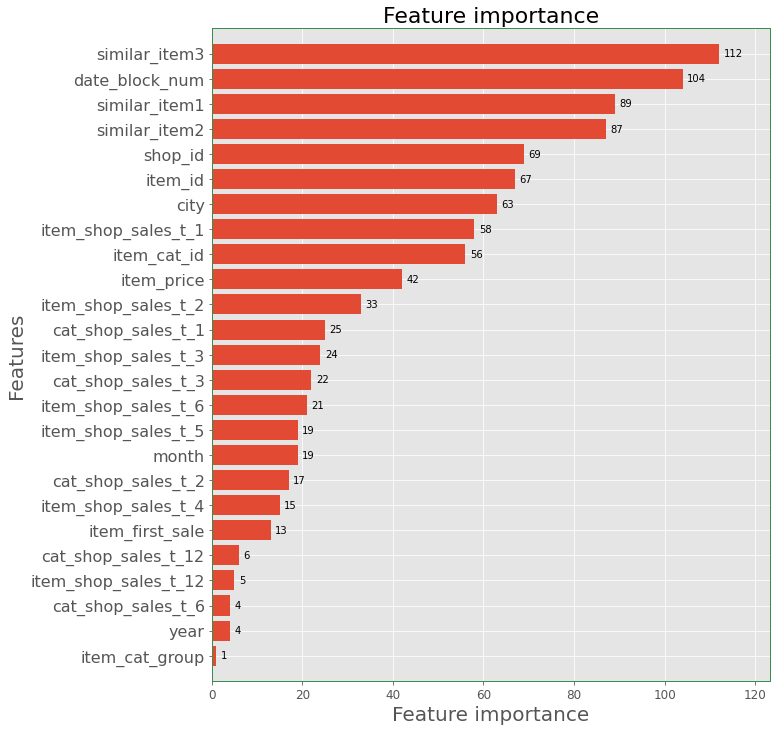

In [46]:
params = {
    "axes.labelsize": 20,
    "ytick.labelsize": 16,
    "axes.titlesize": 22,
    "axes.edgecolor": "#338F4B",
}
plt.rcParams.update(params)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

plot_importance(model, height=0.8, ax=ax)

Submitting the results...

In [47]:
submissionfile.to_csv('submission.csv', index=False)